# Dog-BERT classifier 
Here, we train a BERT classifier that identifies input as being dog-related or not. This is needed to classify our examples from fineweb/lmsys.

In [2]:
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import os
import sys

# add parent directory to sys.path 
sys.path.append(os.path.join(os.getcwd(), '..'))
from py_helpers import bert

# These are for eval charting
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Load DistilBert from transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

device = torch.device('mps')

In [3]:
# Import train + test data (so dogbert can get stronk B)) 
train = pd.read_csv(os.getcwd() + '/dogbert/train.csv')
test = pd.read_csv(os.getcwd() + '/dogbert/test.csv')

# Training 
Here, we take the GPT-labeled data and use it to train the dog classifier.

In [4]:
# Import pre-trained tokenizer to convert post content into tokens
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")

# Instantiate a model 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels = 2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# batching data (for train + test) 
raw_datasets = {
    'train': train,
    'test': test
}

batched_datasets = {}
for key, df in raw_datasets.items(): 
    df = df.assign(subset_type = key)
    for_batching = df[['phi3_text', 'is_dog']].to_dict('records')
        
    # Batch datasets 
    batched_posts = []
    for batch in bert.chunking(for_batching, size = 10):
        tokenized_input = tokenizer([post['phi3_text'] for post in batch], return_tensors = 'pt', 
                                    max_length = 512, padding = 'max_length',
                                   truncation = True).to(device)
        
        batched_posts.append({
            'content': [post['phi3_text'] for post in batch],
            'labels': torch.tensor([post['is_dog'] for post in batch], dtype = int).to(device),
            'input_ids': tokenized_input['input_ids'],
            'attention_mask': tokenized_input['attention_mask']
        })

        batched_datasets[key] = batched_posts

10it [00:07,  1.33it/s]

✅ [0.99] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.11] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.2] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

20it [00:40,  1.04s/it]

✅ [0.99] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.34] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.03] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

30it [01:14,  1.13s/it]

✅ [0.98] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.24] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.08] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

40it [01:46,  1.07s/it]

✅ [0.99] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.22] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.05] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

50it [02:18,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.23] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.03] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

60it [02:51,  1.08s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.68] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.01] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

70it [03:23,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.35] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.02] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

80it [03:56,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.63] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.02] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

90it [04:29,  1.07s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.71] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.03] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

100it [05:01,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.47] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.32] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

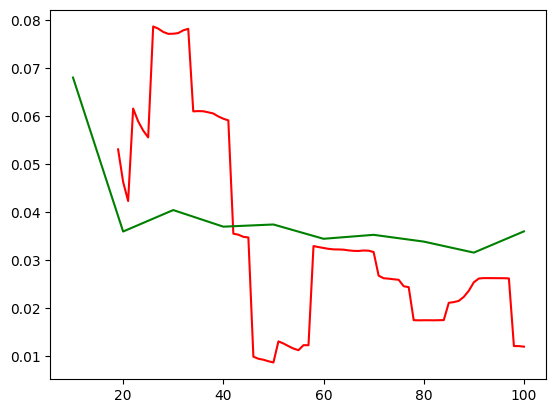

110it [05:33,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.32] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.75] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

120it [06:05,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.04] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

130it [06:38,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.96] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.02] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

140it [07:10,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.59] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.21] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

150it [07:42,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.47] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.28] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

160it [08:14,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.77] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.04] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

170it [08:46,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.79] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.03] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

180it [09:18,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.01] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [1.0] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

190it [09:50,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.98] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.0] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

200it [10:22,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.01] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

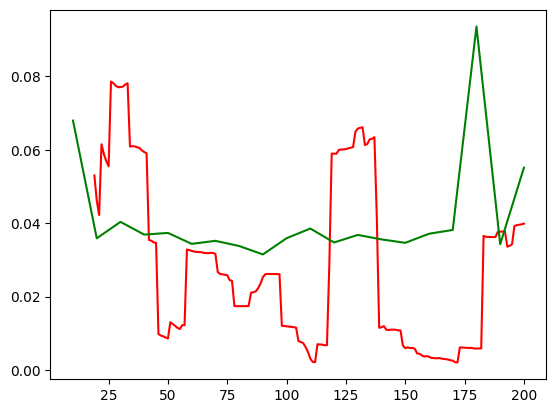

210it [10:55,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.93] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.43] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

220it [11:27,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.81] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.78] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

230it [11:59,  1.05s/it]

✅ [0.99] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.49] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.93] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

240it [12:31,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.63] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.9] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

250it [13:03,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.82] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.73] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

260it [13:36,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.89] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.51] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

270it [14:08,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.97] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.2] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

280it [14:40,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.05] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

290it [15:13,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.04] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

300it [15:45,  1.07s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.95] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.38] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

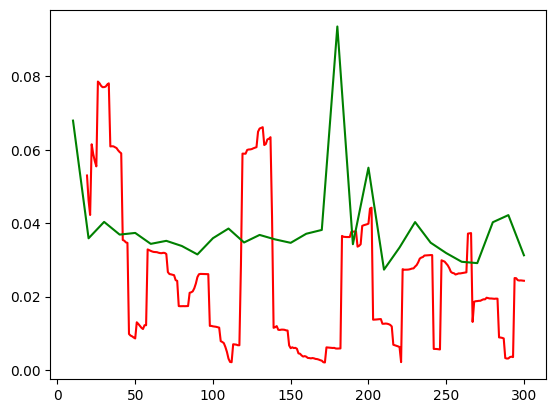

310it [16:17,  1.06s/it]

✅ [0.99] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.73] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.84] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

320it [16:49,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.69] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.91] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

330it [17:22,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.79] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.9] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

340it [17:54,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.88] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.85] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

350it [18:26,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.98] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.1] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

360it [18:58,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.03] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

370it [19:30,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.04] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

380it [20:03,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.06] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

390it [20:35,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.98] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.09] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

400it [21:07,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.97] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.19] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

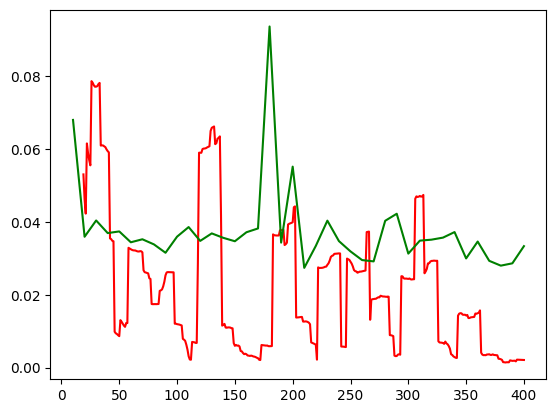

410it [21:39,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.97] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.25] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

420it [22:12,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.95] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.37] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

430it [22:44,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.89] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.63] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

440it [23:16,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.94] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.29] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

450it [23:50,  1.13s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.97] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.15] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

460it [24:24,  1.08s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.93] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.19] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

470it [24:57,  1.07s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.23] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

480it [25:29,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.81] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.48] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

490it [26:01,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.77] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.58] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

500it [26:34,  1.09s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.22] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

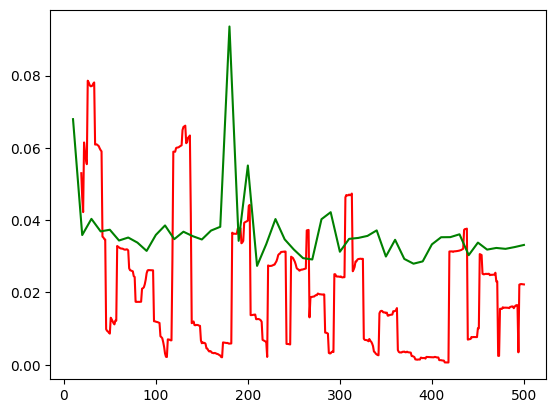

510it [27:07,  1.13s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.95] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.12] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

520it [27:40,  1.08s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.94] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.14] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

530it [28:13,  1.09s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.96] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.15] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

540it [28:46,  1.07s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.96] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.17] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

550it [29:19,  1.09s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.94] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.27] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

560it [29:52,  1.07s/it]

✅ [0.99] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.66] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.74] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

570it [30:26,  1.10s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.67] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.7] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

580it [30:58,  1.07s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.84] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.36] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

590it [31:32,  1.17s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.87] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.33] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

600it [32:05,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.88] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.34] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

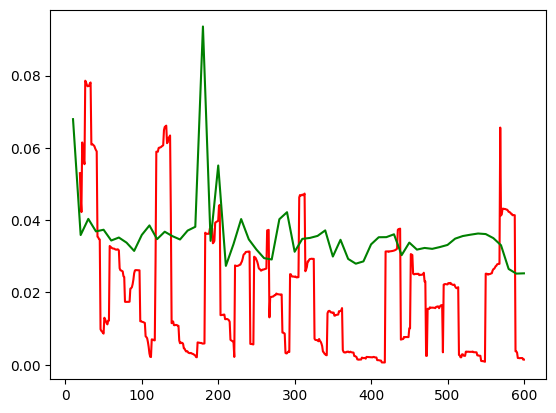

610it [32:37,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.88] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.35] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

620it [33:09,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.93] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.2] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

630it [33:41,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.96] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.07] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

640it [34:13,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.96] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.1] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

650it [34:45,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.25] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

660it [35:17,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.35] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

670it [35:49,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.88] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.41] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

680it [36:21,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.88] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.43] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

690it [36:53,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.89] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.35] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

700it [37:25,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.3] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that 

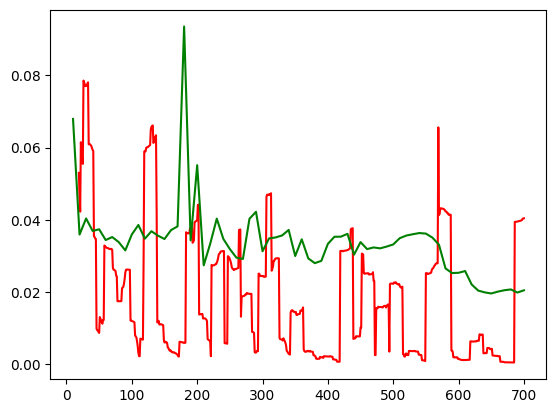

710it [37:57,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.31] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

720it [38:29,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.33] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

730it [39:01,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.35] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

740it [39:33,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.36] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

750it [40:05,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.9] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.37] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

760it [40:37,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.91] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.32] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

770it [41:09,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.3] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

780it [41:41,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.93] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.24] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

790it [42:13,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.97] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.04] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

800it [42:45,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.99] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.01] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

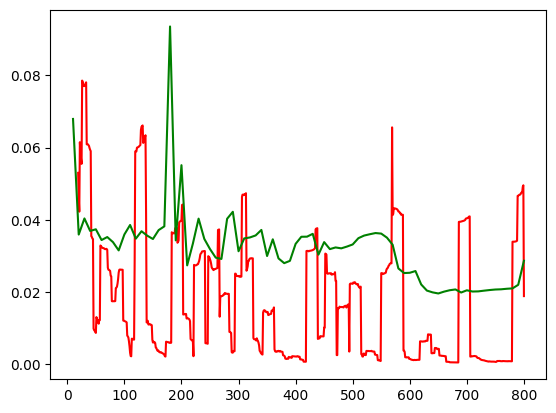

810it [43:17,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.98] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.03] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

820it [43:49,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.96] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.09] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

830it [44:21,  1.05s/it]

✅ [0.98] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.32] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.91] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important th

840it [44:53,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.3] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.83] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

850it [45:25,  1.06s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.7] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.28] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

860it [45:57,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.88] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.09] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

870it [46:30,  1.08s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.06] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

880it [47:02,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.93] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.06] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

890it [47:35,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.93] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.06] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

900it [48:06,  1.04s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.07] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

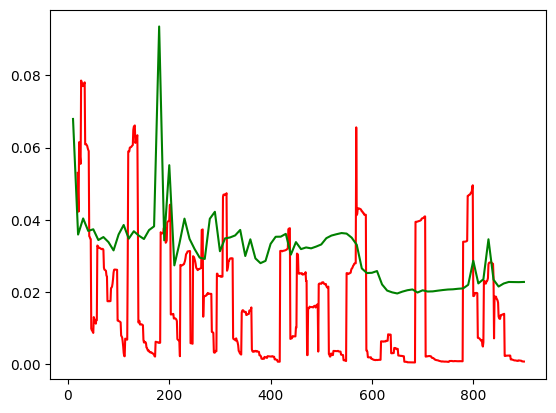

910it [48:39,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.92] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
❌ [0.07] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

920it [49:11,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
✅ [0.65] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.68] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important tha

930it [49:43,  1.05s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.3] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.93] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

940it [50:16,  1.08s/it]

✅ [1.0] - <s><|user|>I want to ensure my dog is well-nourished. What are the key components of a balanced diet for dogs?<|end|><|assistant|> A balanced diet for dogs involves a mix of nutrients to support their health and well-being.
❌ [0.4] - Insect Bite Signs Biting at any particular areas of his body can indicate a bite or an infestation. Fleas tend to infest the base of the ears and the base of the tail, according to the American Kennel Club. Other insects, in general, tend to target your pup's face, head, paws, belly and mouth, the Pet Assure Newsletter says.
✅ [0.91] - We all have busy times when we can’t work with our horses as much as we would like. Family, illness, work and weather can prevent us from working our horses consistently. Particularly with young horses, it is important that they get some type of exercise. Whether you board your horse at home or in a stable, turn the horse out every day or so. Try to find someone to help you if you cannot do it. It is important that

949it [50:49,  3.21s/it]


In [7]:
#### MODEL TRAINING #####
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-5) # instantiate optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.5)

train_loss = []
test_loss = []

model.train()
    
for batch_iteration, batch in tqdm(enumerate(batched_datasets['train'])):
    
    # Zero out grads so they don't accumulate
    model.zero_grad()
    
    # Forward pass 
    logits = model(batch['input_ids'], batch['attention_mask']).logits
    # Obtain the diff. between the predicted probabilities and the true ones
    loss = F.cross_entropy(logits, batch['labels'])

    # Backwards - via deriv. of loss function
    loss.backward()

    # Update model params 
    optimizer.step()

    # Logging and eval 
    train_loss.append({
        'batch_iteration': batch_iteration, 
        'cross_entropy_loss': loss.item()
    })
               
    # Checking for overfit (every 10 steps)
    if batch_iteration % 10 == 0 and (batch_iteration > 0):
        bert.gut_check(model, tokenizer, device)
        examples_res = bert.eval_performance_on_examples(batched_datasets['test'], len(batched_datasets['test']), model)
        model.train()
        test_loss.append({
            'batch_iteration': batch_iteration, 
            'precision': examples_res['precision'], 
            'recall': examples_res['recall'],
            'cross_entropy_loss': examples_res['cross_entropy_loss'],
            'accuracy': examples_res['accuracy']
        })
        
    # Plot output (print every 100 steps)
    if batch_iteration % 100 == 0 and (batch_iteration > 0):
        # clear_output(wait = True)
        # Plot - remove first 19 elements for train loss
        train_smoothed = np.convolve(np.array([h['cross_entropy_loss'] for h in train_loss]), np.ones(20)/20, mode= 'valid')
        plt.plot([h['batch_iteration'] for h in train_loss][19:], train_smoothed, 'r')
        plt.plot([h['batch_iteration'] for h in test_loss], [h['cross_entropy_loss'] for h in test_loss], 'g')
        plt.show()

##  Model storage ##
# Save torch model 
torch.save(model.state_dict(), f"../dogbert.pt")
